In [2]:
'''
* Necessary libraries for the tool
- numpy
- networkx
- matplotlib
- pulp
- munkres
'''

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pulp

from typing import List, Dict
from munkres import Munkres, make_cost_matrix

In [3]:
'''
* [Entity] represents the different entities who are involved in the trading.
*
* They can be any of:
* - Buyer
* - Seller
* - Prosumer
'''
class Entity:
    def __init__(self,
            title: str,
            label: str,
            priority: int, # unused
            position: int # unused
        ):
        self.title = title
        self.label = label
        self.priority = priority # unused
        self.position = position # unused

    def __repr__(self):
        return f"[{self.priority}] {self.title} ({self.label}) @ {self.position}"

In [4]:
'''
* [SNode] is used to store an instance of an entity who is selling an item.
'''
class SNode:
    def __init__(self,
            label: str,
            quantity: int,
            price: float
        ):
        self.label = label
        self.quantity = quantity
        self.price = price
        self.total = price * quantity

    def __repr__(self):
        return f"{self.label}:{self.quantity}x${self.price}:${self.total:.2f}"

    def render(self):
        return f"{self.label}:${self.total:.2f}\n{self.quantity}x${self.price}"

In [5]:
'''
* [BNode] is used to store an instance of an entity who is buying an item.
'''
class BNode:
    def __init__(self,
            label: str,
            total: float
        ):
        self.label = label
        self.total = total

    def __repr__(self):
        return f"{self.label}:${self.total:.2f}"

    def render(self):
        return f"{self.label}:${self.total:.2f}"

    def broker(self,
            seller: SNode
        ) -> float:

        if seller.price == 0:
            return 0

        ideal = self.total // seller.price
        return min(ideal, seller.quantity) * seller.price

In [6]:
'''
* [Base] stores the inital setup of the trading matrix
'''
class Base:
    def __init__(self,
            size: int,
            buyers: List[BNode],
            sellers: List[SNode]
        ):
        self.matrix = np.zeros((size,size))

        for row in range(size):
            for col in range(size):
                if (buyers[row].label != sellers[col].label
                    and buyers[row].label != "&B"
                    and sellers[col].label != "&S"
                ):
                    self.matrix[row][col] = sellers[col].price

In [7]:
'''
* [Hungarian] stores the "brokered" matrix, as well as the hungarian matrix solution
'''
class Hungarian:
    def __init__(self,
            size: int,
            buyers: List[BNode],
            sellers: List[SNode]
        ):
        self.matrix = np.zeros((size,size))
        self.solution = np.zeros((size,size))
        self.total: float = 0

        solo_case_guard:bool = False

        for row in range(size):
            for col in range(size):
                if buyers[row].label != sellers[col].label:
                    self.matrix[row][col] = buyers[row].broker(sellers[col])
                    solo_case_guard = True

        if solo_case_guard:
            m = Munkres()
            cost = make_cost_matrix(self.matrix)
            indexes = m.compute(cost)

            for row, col in indexes:
                value = buyers[row].broker(sellers[col])
                self.solution[row][col] = value
                self.total += value

In [8]:
'''
* [ILP] stores the decision variable matrix, as well as the integer linear programming solution
'''
class ILP:
    def __init__(self,
            size: int,
            buyers: List[BNode],
            sellers: List[SNode]
        ):
        self.matrix = np.zeros((size, size), dtype=object)
        self.solution = np.zeros((size,size))
        self.total: float = 0

        for row in range(size):
            for col in range(size):
                if (buyers[row].label == sellers[col].label
                    or buyers[row].label == "&B"
                    or sellers[col].label == "&S"
                ):
                    self.matrix[row][col] = 0.0
                else:
                    self.matrix[row][col] = pulp.LpVariable(f'q_{buyers[row].label}_{sellers[col].label}', lowBound=0, cat="Integer")

        problem = pulp.LpProblem("max", pulp.LpMaximize)

        problem += pulp.lpSum([
            sellers[col].price * self.matrix[row][col]
            for row in range(size)
            for col in range(size)
            if buyers[row].label != sellers[col].label
            and buyers[row].label != "&B"
            and sellers[col].label != "&S"
        ])

        for row in range(size):
            problem += (pulp.lpSum(sellers[col].price * self.matrix[row][col]
                for col in range(size)) <= buyers[row].total), f"{buyers[row].label}_BC"

        for col in range(size):
            problem += (pulp.lpSum(sellers[col].price * self.matrix[row][col]
                for row in range(size)) <= sellers[col].total), f"{sellers[col].label}_SC"

        problem.solve(pulp.PULP_CBC_CMD(msg=False))

        for row in range(size):
            for col in range(size):
                if pulp.value(self.matrix[row][col]) is not None:
                    value = pulp.value(self.matrix[row][col]) * sellers[col].price
                    self.solution[row][col] = value
                    self.total += value

In [9]:
'''
* [HILP] same as the ILP class, just with the extra constraints from the hungarian solution
'''
class HILP:
    def __init__(self,
            size: int,
            buyers: List[BNode],
            sellers: List[SNode],
            influence: np.ndarray[np.float64]
        ):
        self.matrix = np.zeros((size, size), dtype=object)
        self.solution = np.zeros((size,size))
        self.total: float = 0

        for row in range(size):
            for col in range(size):
                if (buyers[row].label == sellers[col].label
                    or buyers[row].label == "&B"
                    or sellers[col].label == "&S"
                ):
                    self.matrix[row][col] = 0.0
                else:
                    self.matrix[row][col] = pulp.LpVariable(f'q_{buyers[row].label}_{sellers[col].label}', lowBound=0, cat="Integer")

        problem = pulp.LpProblem("max", pulp.LpMaximize)

        problem += pulp.lpSum([
            sellers[col].price * self.matrix[row][col]
            for row in range(size)
            for col in range(size)
            if buyers[row].label != sellers[col].label
            and buyers[row].label != "&B"
            and sellers[col].label != "&S"
        ])

        for row in range(size):
            problem += (pulp.lpSum(sellers[col].price * self.matrix[row][col]
                for col in range(size)) <= buyers[row].total), f"{buyers[row].label}_BC"

        for col in range(size):
            problem += (pulp.lpSum(sellers[col].price * self.matrix[row][col]
                for row in range(size)) <= sellers[col].total), f"{sellers[col].label}_SC"

        for row in range(size):
            for col in range(size):
                if influence[row][col] != 0 and self.matrix[row][col] != 0:
                    problem += (self.matrix[row][col] >= 1), f"I_{row}_{col}"

        problem.solve(pulp.PULP_CBC_CMD(msg=False))

        for row in range(size):
            for col in range(size):
                if pulp.value(self.matrix[row][col]) is not None:
                    value = pulp.value(self.matrix[row][col]) * sellers[col].price
                    self.solution[row][col] = value
                    self.total += value

In [10]:
'''
* [Priority] unused
'''
class Priority:
    def __init__(self,
            size: int,
            buyers: List[BNode],
            sellers: List[SNode],
            entities: Dict[str,Entity]
        ):
        pass

In [11]:
'''
* [Simulation] used to store a given trading matrix (and its current state)
'''
class Simulation:
    def __init__(self,
            title: str,
            distance_limit: float,
            entities: Dict[str,Entity],
            size: int,
            buyers: List[BNode],
            sellers: List[SNode]
        ):
        self.title = title
        self.distance_limit = distance_limit
        self.entities = entities
        self.size = size
        self.buyers = buyers
        self.sellers = sellers

        while len(buyers) < size:
            buyers.append(BNode("&B",0.0))

        while len(sellers) < size:
            sellers.append(SNode("&S",0,0.0))

        # * BASE STATE
        self.base = Base(size, buyers, sellers)

        # * HUNGARIAN STATE
        self.hung = Hungarian(size, buyers, sellers)

        # * LINEAR INTEGER PROGRAMING STATE
        self.ilp = ILP(size, buyers, sellers)

        # * HUNGARIAN LINEAR INTEGER PROGRAMING STATE
        self.hilp = HILP(size, buyers, sellers, self.hung.solution)

    def __repr__(self):
        return f"{self.title}"

    def Display(self,
        matrix: np.ndarray[np.float64]
    ):
        graph = nx.Graph()

        for row in range(self.size):
            for col in range(self.size):
                graph.add_edge(self.buyers[row], self.sellers[col], weight = round(matrix[row][col], 2) if isinstance(matrix[row][col], float) else matrix[row][col])

        pos = nx.drawing.layout.bipartite_layout(graph, self.buyers)
        pos = {key: (x, -y) for key, (x, y) in pos.items()}
        labels = {node: node.render() for node in graph.nodes()}

        edge_colors = []
        for (u, v, d) in graph.edges(data=True):
            weight = d["weight"]
            if ((weight == 0
                or weight == np.inf)
                and not isinstance(weight, pulp.LpVariable)
            ):
                edge_colors.append((1,0,0,0.25))
            else:
                edge_colors.append((0,0,0,1))

        # Set up figure to use full screen size for reduced whitespace
        plt.figure(figsize=(5.25,5.25))  # Control figure size (w x h)

        # Draw graph
        nx.draw(graph, pos, edge_color=edge_colors, width=1.5, node_size=4000, font_size=10, font_color="white", with_labels=True, labels=labels)

        edge_labels = {(u, v): label for (u, v), label in nx.get_edge_attributes(graph, "weight").items() if label != 0}

        ax = plt.gca()

        # Print edge weights symmetrically, reflected over the middle line
        for (u, v), label in edge_labels.items():
            x_u, y_u = pos[u]
            x_v, y_v = pos[v]

            # Midpoint between the two nodes
            mid_x, mid_y = (x_u + x_v) / 2, (y_u + y_v) / 2

            # Offset value
            offset = 0.2

            # Offset distance to avoid overlapping with node labels
            offset_x = offset * (x_v - x_u)
            offset_y = offset * (y_v - y_u)

            # Position the labels symmetrically on both sides of the middle line
            label_pos_start = (x_u + offset_x, y_u + offset_y)
            label_pos_end = (x_v - offset_x, y_v - offset_y)

            ax.text(*label_pos_start, s=label, bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, ha='center', va='center')
            ax.text(*label_pos_end, s=label, bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, ha='center', va='center')

        print(matrix, end="\n\n")

        plt.show()

In [12]:
'''
* Our test example loader
'''

simulations: List[Simulation] = []

file = open("input.txt", "r")

sim_title: str = ""
sim_distance_limit: float = np.inf
sim_entities: Dict[str,Entity] = {}
sim_buyers: List[BNode] = []
sim_sellers: List[SNode] = []

In [13]:
'''
* Read input in the input.txt file
'''

for line in file:

    match line[0]:

        case "!":
            sim_title = line.strip("\n!")
            sim_distance_limit: float = np.inf
            sim_entities: Dict[str,Entity] = {}
            sim_buyers: List[BNode] = []
            sim_sellers: List[SNode] = []

        case "|":
            sim_distance_limit = float(line.strip("|"))

        case "-":
            line_split = line.split(":")
            cord_split = line_split[3].strip("\n()").split(",")

            title = line_split[0].strip("-")
            label = line_split[1]
            priority = int(line_split[2])
            x = float(cord_split[0])
            y = float(cord_split[1])

            sim_entities[label] = Entity(title, label, priority, 0)

        case "<":
            line_split = line.strip("\n<")
            sim_buyers.append(BNode(label, float(line_split)))

        case ">":
            line_split = line.strip("\n>").split(":")
            sim_sellers.append(SNode(label, float(line_split[0]), float(line_split[1])))

        case "&":
            sim_size = max(len(sim_buyers), len(sim_sellers))
            simulations.append(Simulation(sim_title, sim_distance_limit, sim_entities, sim_size, sim_buyers, sim_sellers))

        case _:
            continue

file.close()

simulation 10
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('B3', [0] Co3 (B3) @ 0)
('S1', [0] Co4 (S1) @ 0)
('S2', [0] Co5 (S2) @ 0)
('S3', [0] Co6 (S3) @ 0)

base
[[1.5 2.5 1.1]
 [1.5 2.5 1.1]
 [1.5 2.5 1.1]]



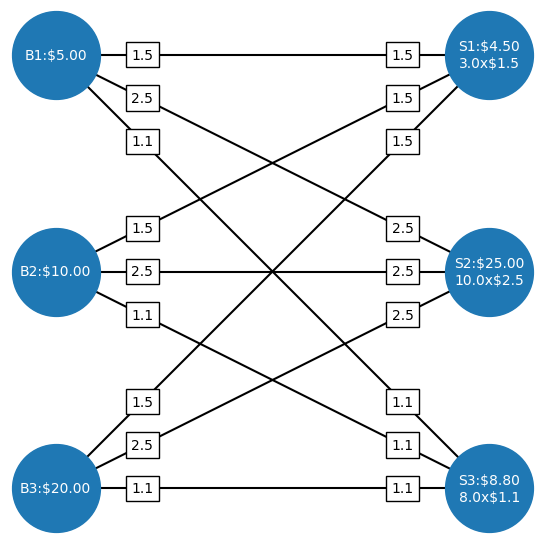

brokered
[[ 4.5  5.   4.4]
 [ 4.5 10.   8.8]
 [ 4.5 20.   8.8]]



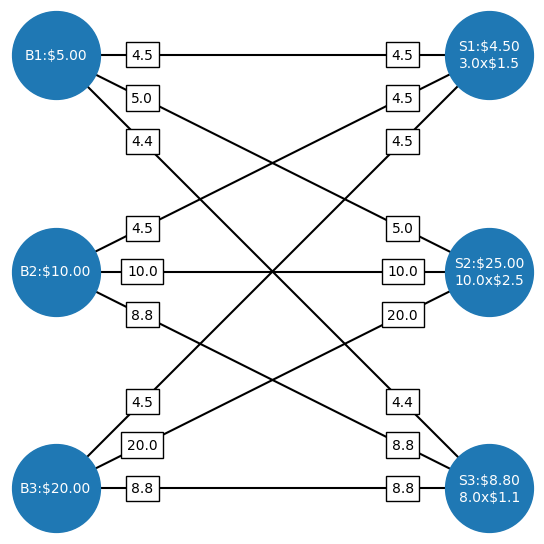

hung sol
[[ 4.5  0.   0. ]
 [ 0.   0.   8.8]
 [ 0.  20.   0. ]]



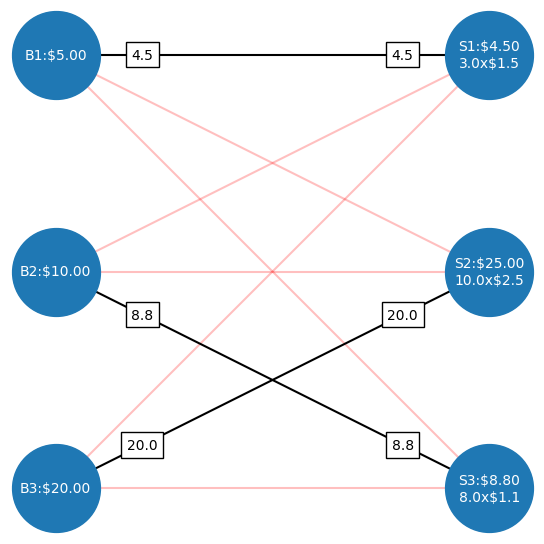

ilp
[[q_B1_S1 q_B1_S2 q_B1_S3]
 [q_B2_S1 q_B2_S2 q_B2_S3]
 [q_B3_S1 q_B3_S2 q_B3_S3]]



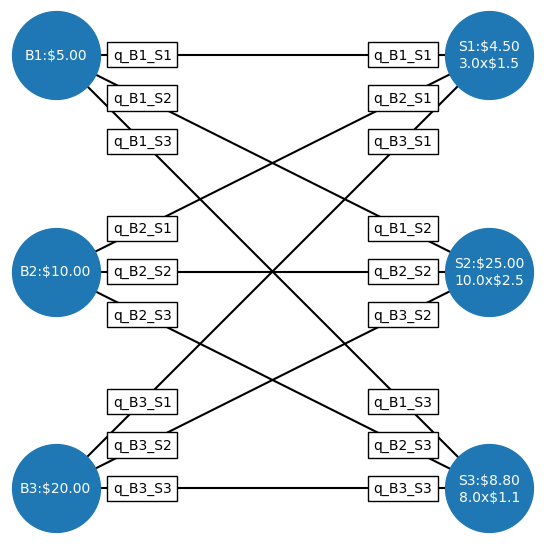

ilp sol
[[ 0.   5.   0. ]
 [ 0.  10.   0. ]
 [ 4.5 10.   5.5]]



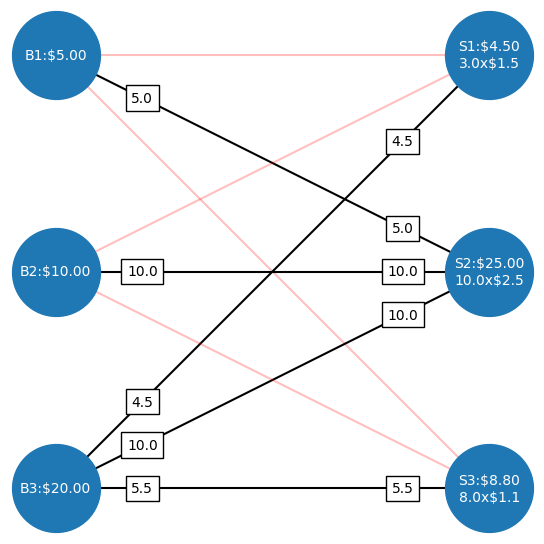

hilp sol
[[ 1.5  0.   3.3]
 [ 3.   2.5  4.4]
 [ 0.  20.   0. ]]



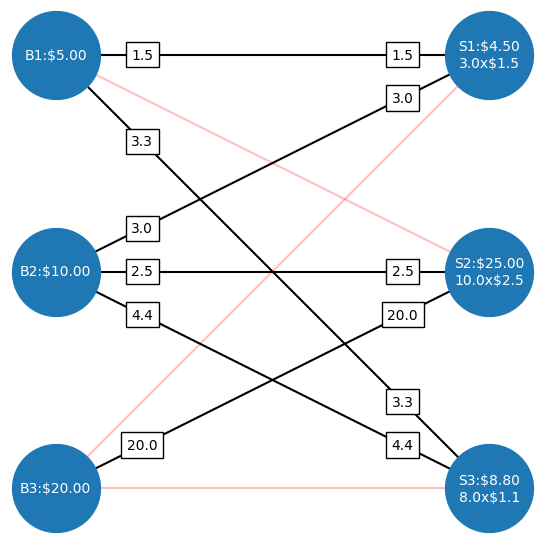

buyer total: 35.00
seller total: 38.30
theo solution: 35.00

hungarian solution: 33.30
ilp solution: 35.00
hilp solution: 34.70

theo waste: 3.30
hung waste: 5.00
ilp waste: 3.30
hilp waste: 3.60

End simulation 10

simulation 1
('B1', [0] Co1 (B1) @ 0)
('S1', [0] Co2 (S1) @ 0)

base
[[2.]]



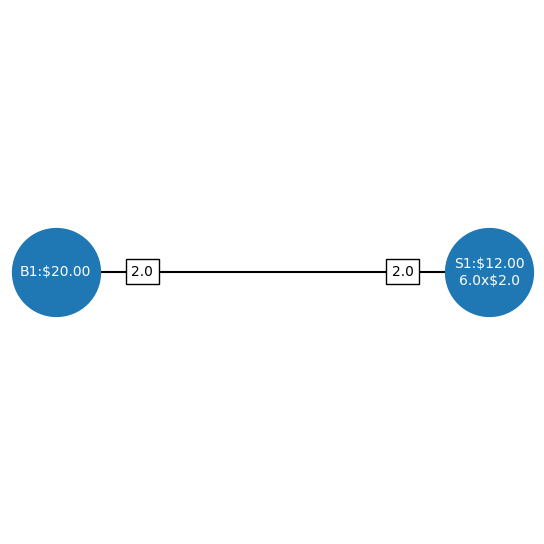

brokered
[[12.]]



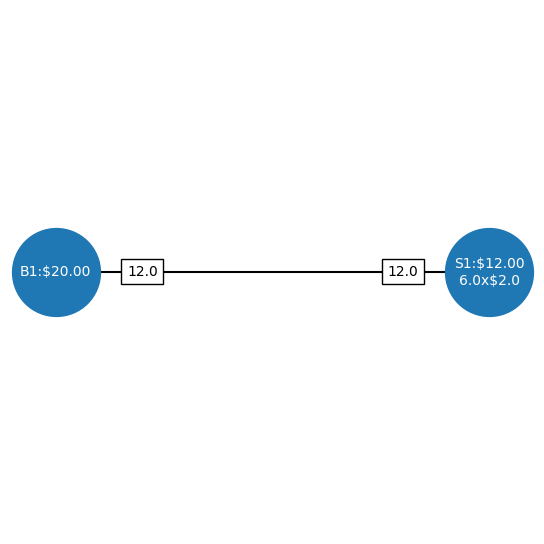

hung sol
[[12.]]



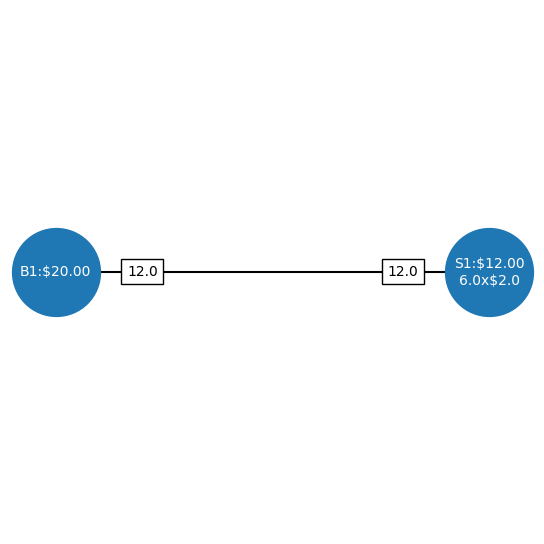

ilp
[[q_B1_S1]]



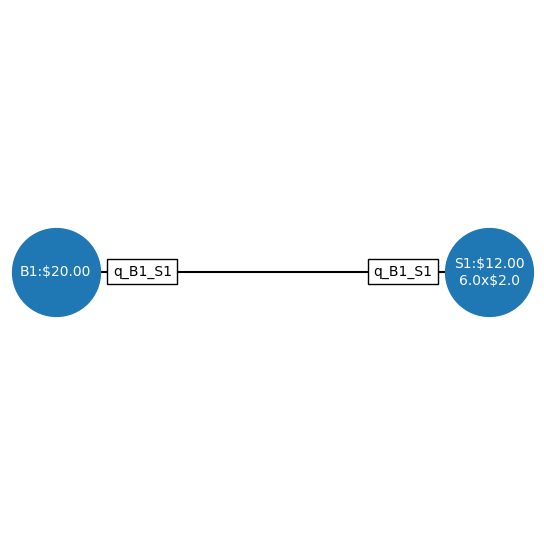

ilp sol
[[12.]]



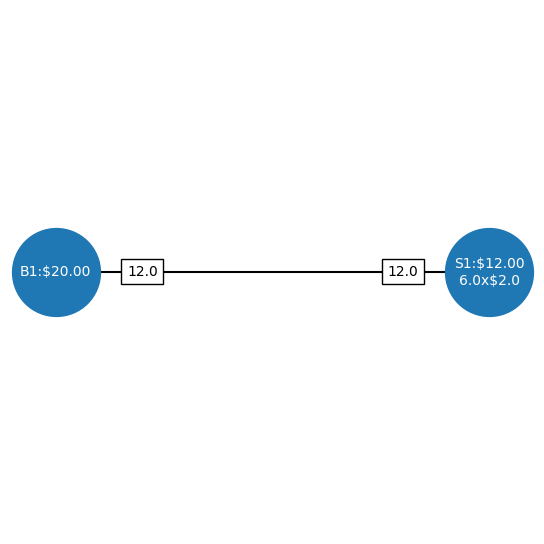

hilp sol
[[12.]]



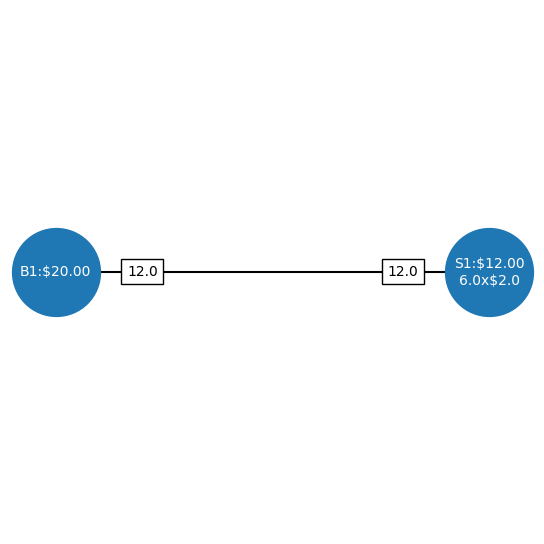

buyer total: 20.00
seller total: 12.00
theo solution: 12.00

hungarian solution: 12.00
ilp solution: 12.00
hilp solution: 12.00

theo waste: 8.00
hung waste: 8.00
ilp waste: 8.00
hilp waste: 8.00

End simulation 1

simulation 2
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('B3', [0] Co3 (B3) @ 0)
('S1', [0] Co4 (S1) @ 0)
('S2', [0] Co5 (S2) @ 0)
('S3', [0] Co6 (S3) @ 0)

base
[[  5.  10. 250.]
 [  5.  10. 250.]
 [  5.  10. 250.]]



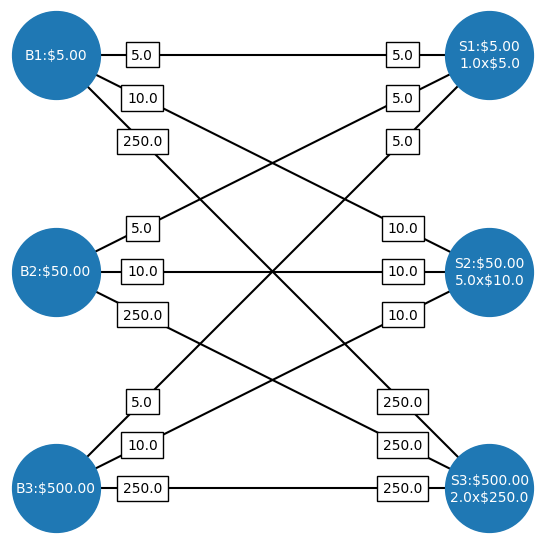

brokered
[[  5.   0.   0.]
 [  5.  50.   0.]
 [  5.  50. 500.]]



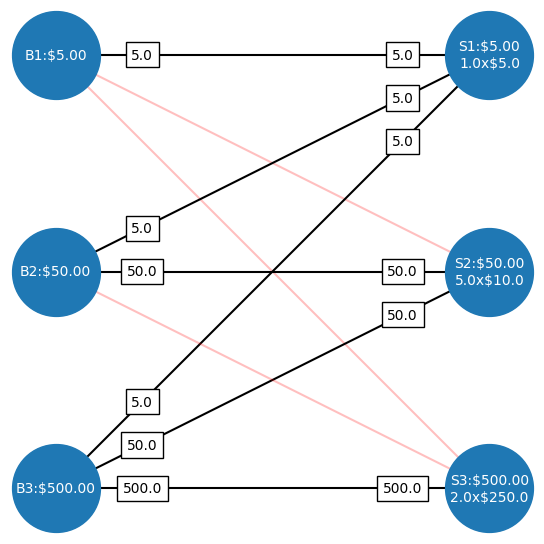

hung sol
[[  5.   0.   0.]
 [  0.  50.   0.]
 [  0.   0. 500.]]



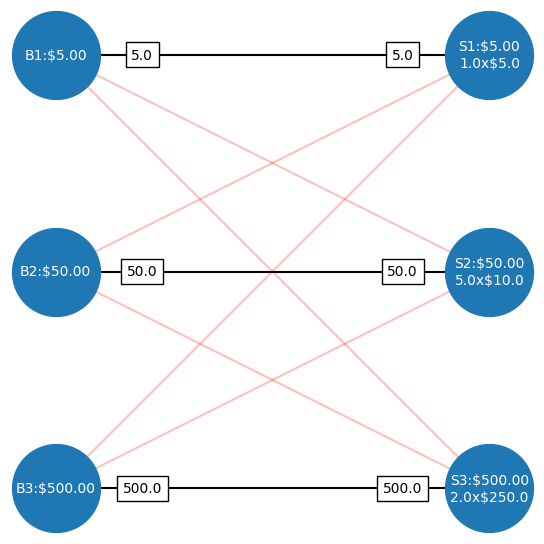

ilp
[[q_B1_S1 q_B1_S2 q_B1_S3]
 [q_B2_S1 q_B2_S2 q_B2_S3]
 [q_B3_S1 q_B3_S2 q_B3_S3]]



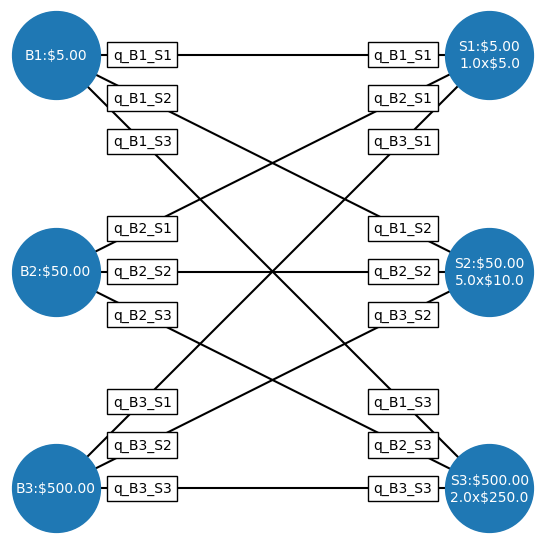

ilp sol
[[  5.   0.   0.]
 [  0.  50.   0.]
 [  0.   0. 500.]]



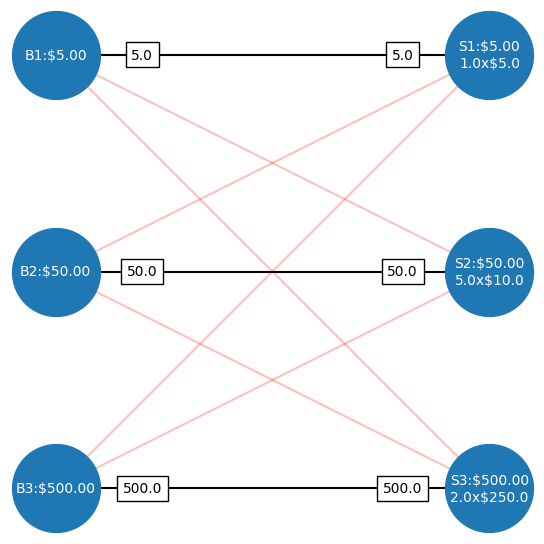

hilp sol
[[  5.   0.   0.]
 [  0.  50.   0.]
 [  0.   0. 500.]]



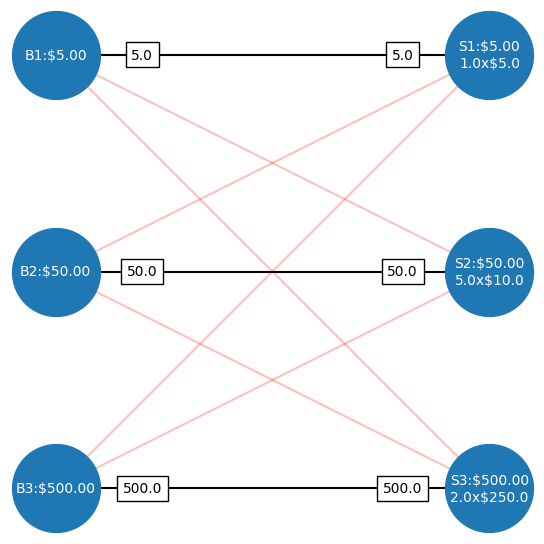

buyer total: 555.00
seller total: 555.00
theo solution: 555.00

hungarian solution: 555.00
ilp solution: 555.00
hilp solution: 555.00

theo waste: 0.00
hung waste: 0.00
ilp waste: 0.00
hilp waste: 0.00

End simulation 2

simulation 3
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('S1', [0] Co3 (S1) @ 0)
('S2', [0] Co4 (S2) @ 0)
('S3', [0] Co5 (S3) @ 0)

base
[[ 7.    2.25 23.2 ]
 [ 7.    2.25 23.2 ]
 [ 0.    0.    0.  ]]



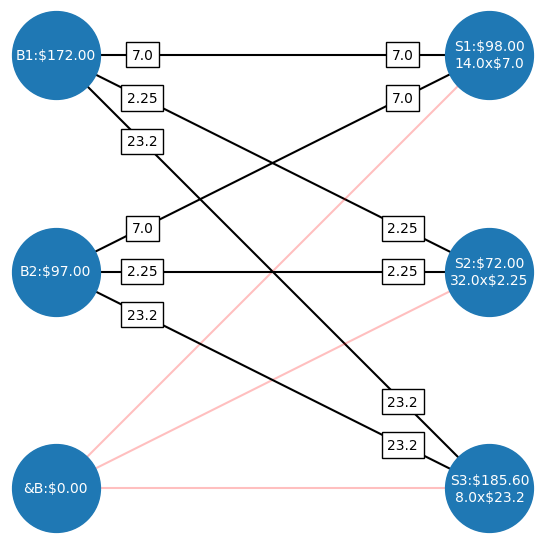

brokered
[[ 98.   72.  162.4]
 [ 91.   72.   92.8]
 [  0.    0.    0. ]]



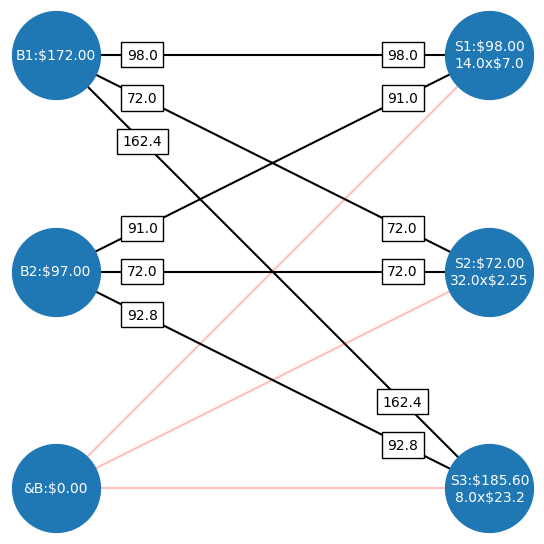

hung sol
[[  0.    0.  162.4]
 [ 91.    0.    0. ]
 [  0.    0.    0. ]]



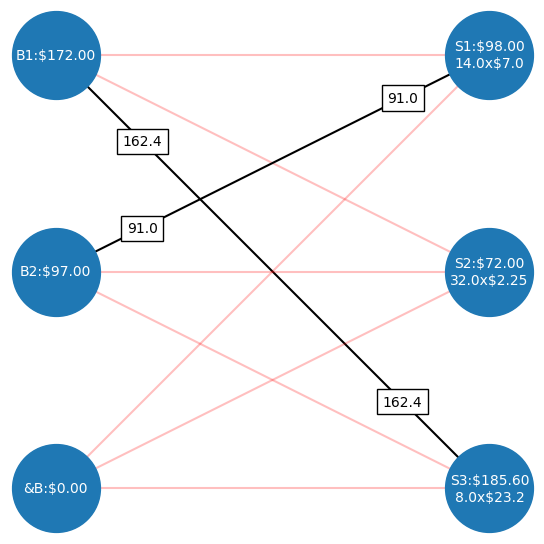

ilp
[[q_B1_S1 q_B1_S2 q_B1_S3]
 [q_B2_S1 q_B2_S2 q_B2_S3]
 [0.0 0.0 0.0]]



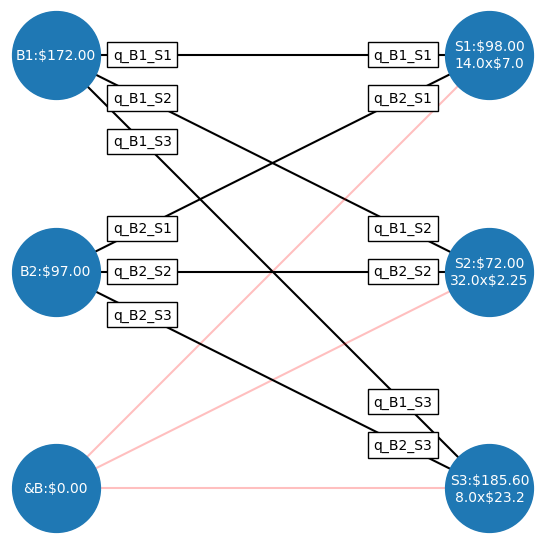

ilp sol
[[ 56.    0.  116. ]
 [ 28.   22.5  46.4]
 [  0.    0.    0. ]]



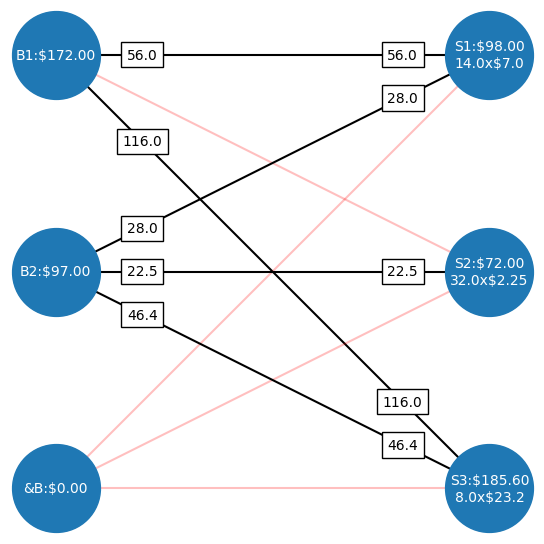

hilp sol
[[ 56.    0.  116. ]
 [ 28.   22.5  46.4]
 [  0.    0.    0. ]]



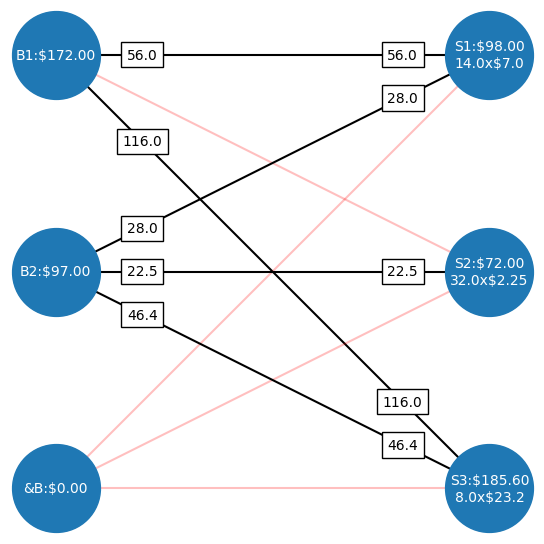

buyer total: 269.00
seller total: 355.60
theo solution: 269.00

hungarian solution: 253.40
ilp solution: 268.90
hilp solution: 268.90

theo waste: 86.60
hung waste: 102.20
ilp waste: 86.70
hilp waste: 86.70

End simulation 3

simulation 4
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('B3', [0] Co3 (B3) @ 0)
('S1', [0] Co4 (S1) @ 0)
('S2', [0] Co5 (S2) @ 0)

base
[[16.22  1.57  0.  ]
 [16.22  1.57  0.  ]
 [16.22  1.57  0.  ]]



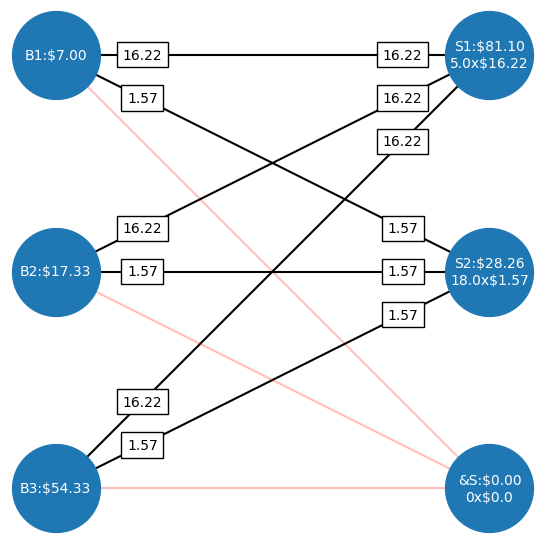

brokered
[[ 0.    6.28  0.  ]
 [16.22 17.27  0.  ]
 [48.66 28.26  0.  ]]



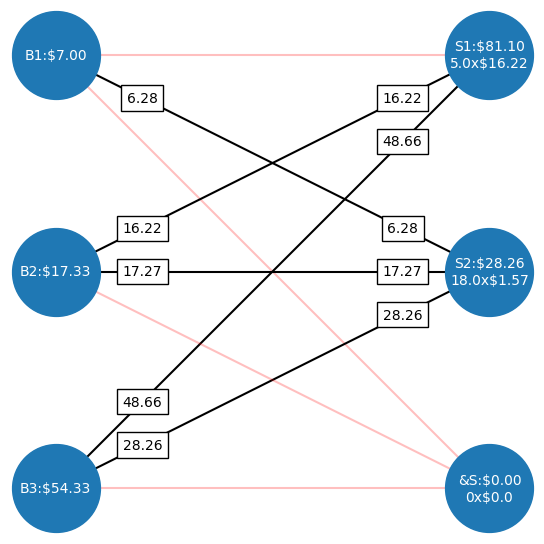

hung sol
[[ 0.    0.    0.  ]
 [ 0.   17.27  0.  ]
 [48.66  0.    0.  ]]



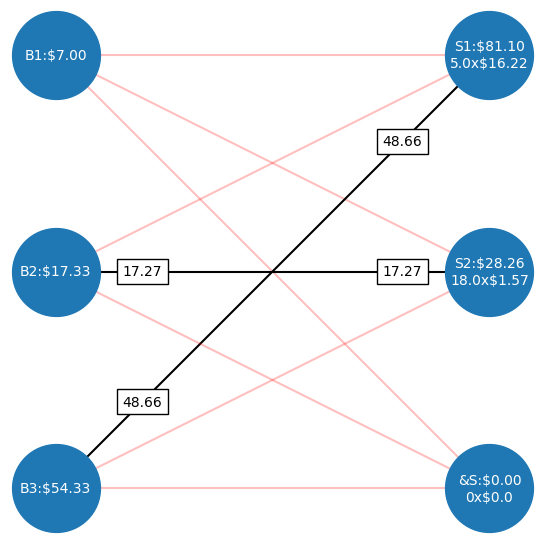

ilp
[[q_B1_S1 q_B1_S2 0.0]
 [q_B2_S1 q_B2_S2 0.0]
 [q_B3_S1 q_B3_S2 0.0]]



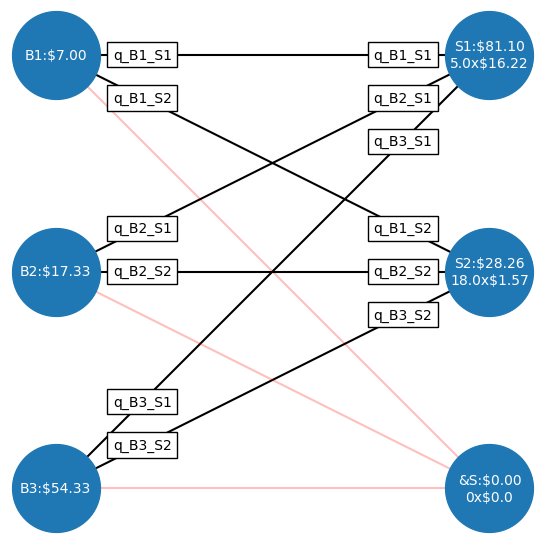

ilp sol
[[ 0.    6.28  0.  ]
 [ 0.   17.27  0.  ]
 [48.66  4.71  0.  ]]



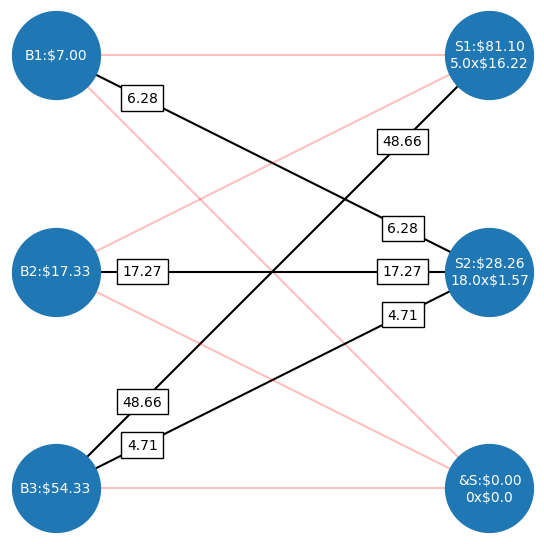

hilp sol
[[ 0.    6.28  0.  ]
 [ 0.   17.27  0.  ]
 [48.66  4.71  0.  ]]



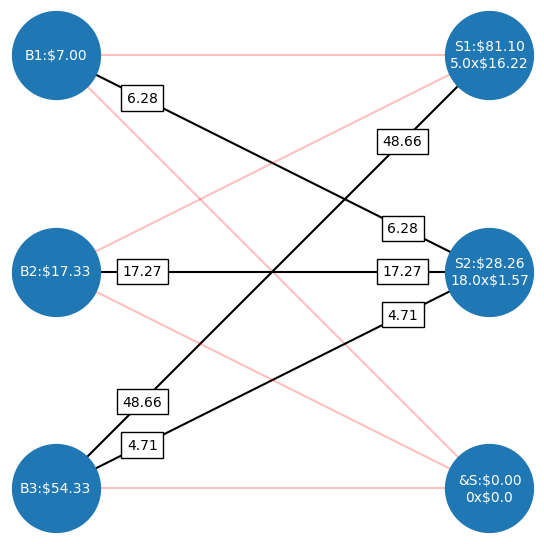

buyer total: 78.66
seller total: 109.36
theo solution: 78.66

hungarian solution: 65.93
ilp solution: 76.92
hilp solution: 76.92

theo waste: 30.70
hung waste: 43.43
ilp waste: 32.44
hilp waste: 32.44

End simulation 4

simulation 5
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('S1', [0] Co3 (S1) @ 0)
('S2', [0] Co4 (S2) @ 0)
('P1', [0] Co5 (P1) @ 0)

base
[[5. 3. 8.]
 [5. 3. 8.]
 [5. 3. 0.]]



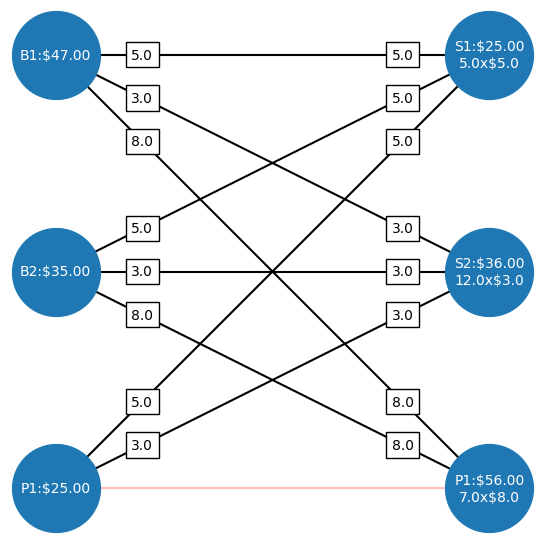

brokered
[[25. 36. 40.]
 [25. 33. 32.]
 [25. 24.  0.]]



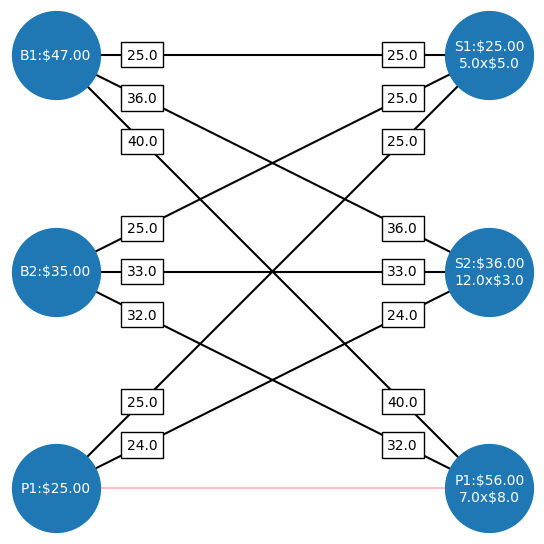

hung sol
[[ 0.  0. 40.]
 [ 0. 33.  0.]
 [25.  0.  0.]]



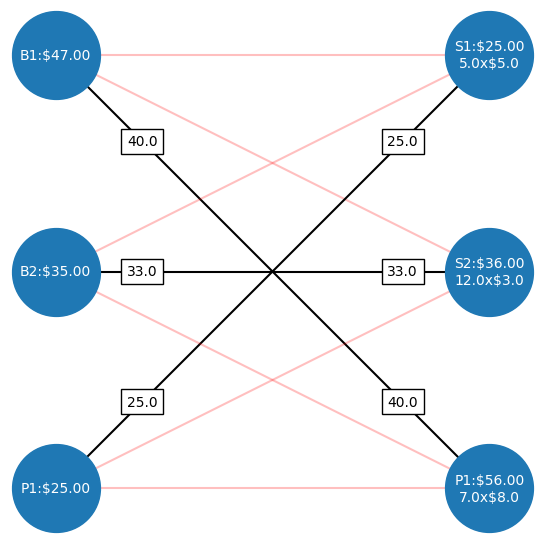

ilp
[[q_B1_S1 q_B1_S2 q_B1_P1]
 [q_B2_S1 q_B2_S2 q_B2_P1]
 [q_P1_S1 q_P1_S2 0.0]]



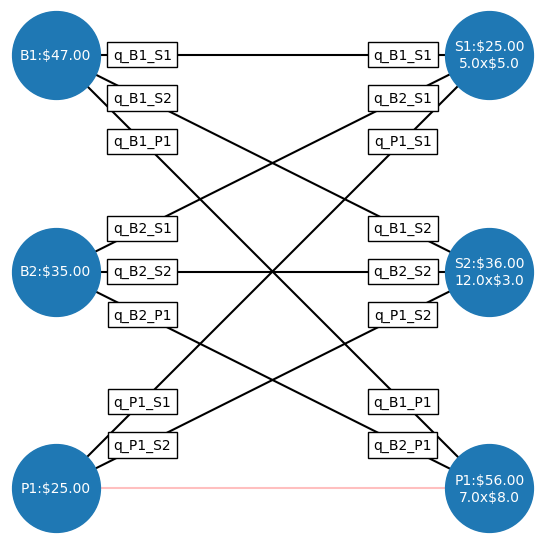

ilp sol
[[ 5. 18. 24.]
 [ 0.  3. 32.]
 [10. 15.  0.]]



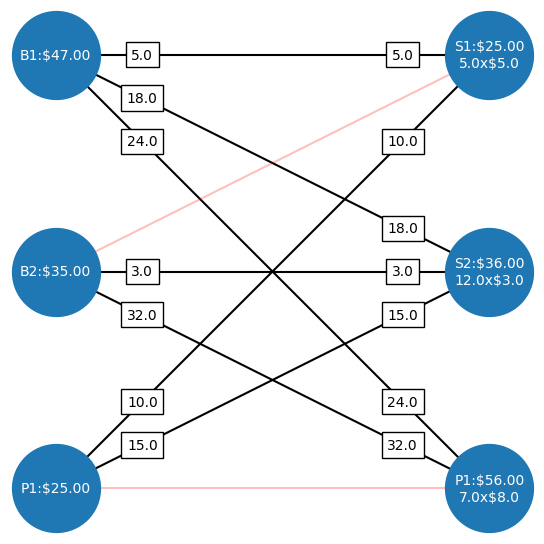

hilp sol
[[ 5. 18. 24.]
 [ 0.  3. 32.]
 [10. 15.  0.]]



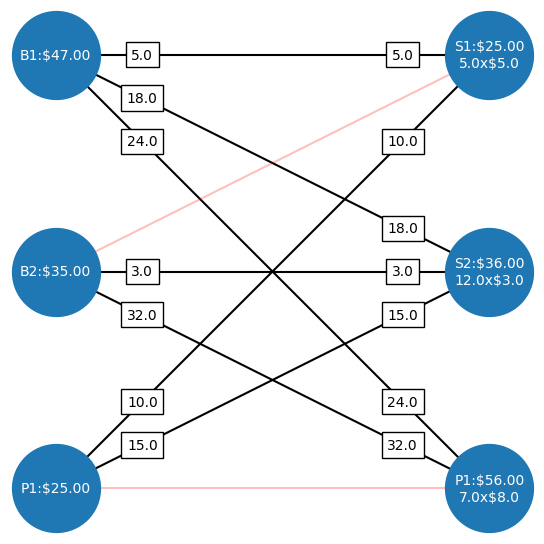

buyer total: 107.00
seller total: 117.00
theo solution: 107.00

hungarian solution: 98.00
ilp solution: 107.00
hilp solution: 107.00

theo waste: 10.00
hung waste: 19.00
ilp waste: 10.00
hilp waste: 10.00

End simulation 5

simulation 6
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('S1', [0] Co3 (S1) @ 0)
('S2', [0] Co4 (S2) @ 0)
('P1', [0] Co5 (P1) @ 0)

base
[[8. 3. 8.]
 [8. 3. 8.]
 [8. 3. 0.]]



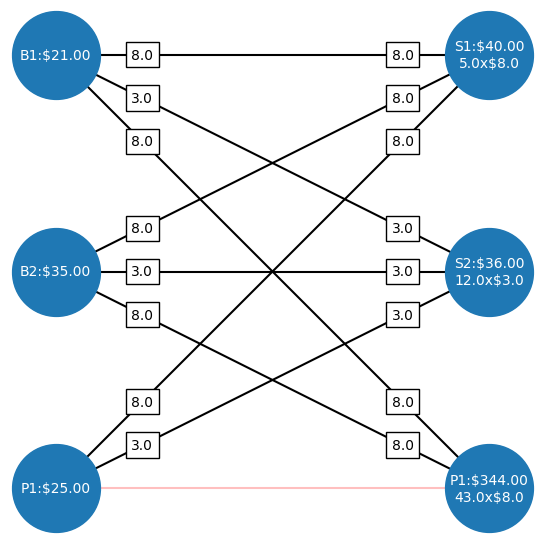

brokered
[[16. 21. 16.]
 [32. 33. 32.]
 [24. 24.  0.]]



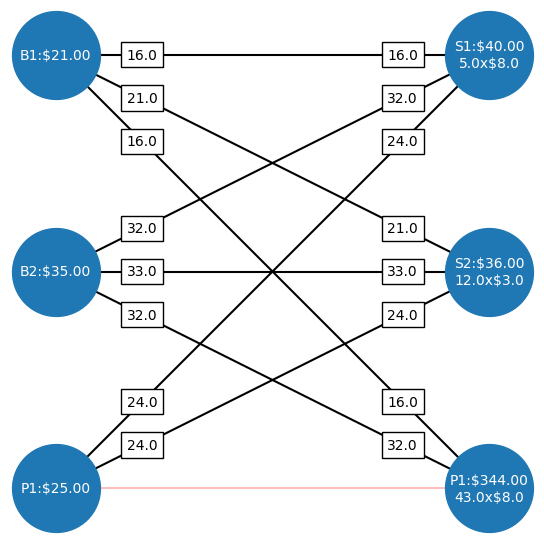

hung sol
[[ 0. 21.  0.]
 [ 0.  0. 32.]
 [24.  0.  0.]]



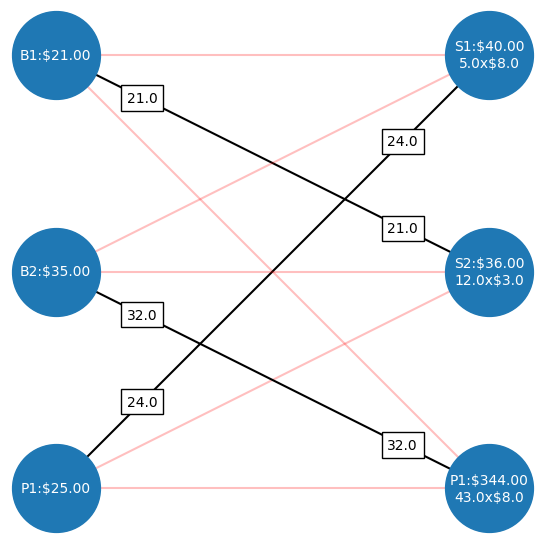

ilp
[[q_B1_S1 q_B1_S2 q_B1_P1]
 [q_B2_S1 q_B2_S2 q_B2_P1]
 [q_P1_S1 q_P1_S2 0.0]]



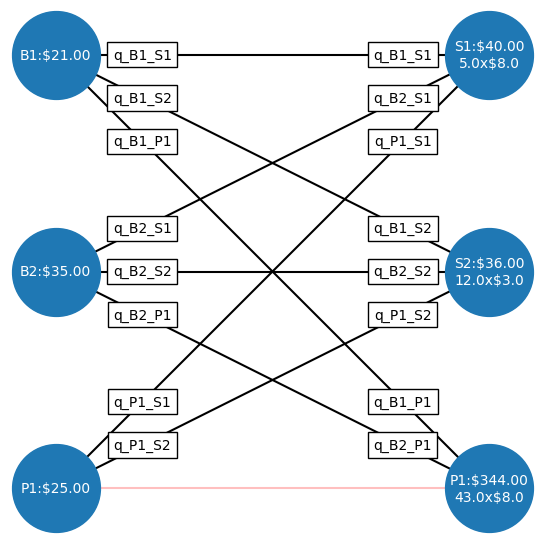

ilp sol
[[ 0. 21.  0.]
 [ 0.  3. 32.]
 [16.  9.  0.]]



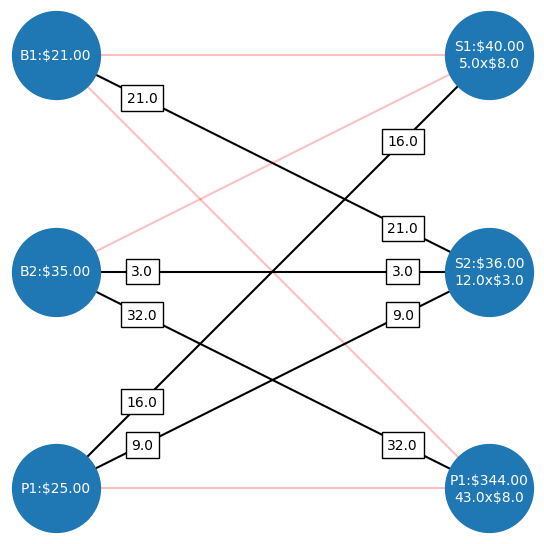

hilp sol
[[ 0. 21.  0.]
 [ 0.  3. 32.]
 [16.  9.  0.]]



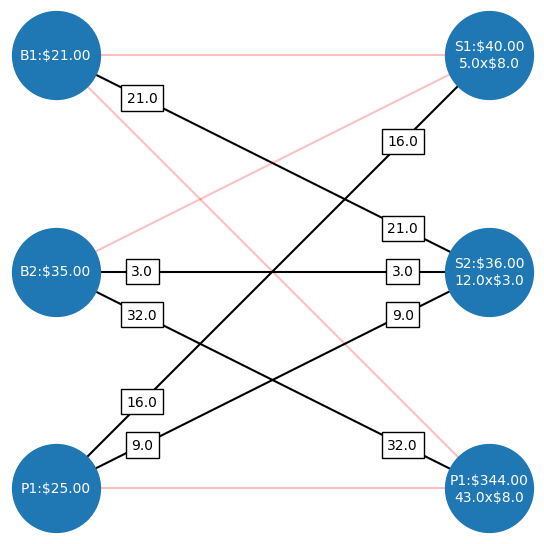

buyer total: 81.00
seller total: 420.00
theo solution: 81.00

hungarian solution: 77.00
ilp solution: 81.00
hilp solution: 81.00

theo waste: 339.00
hung waste: 343.00
ilp waste: 339.00
hilp waste: 339.00

End simulation 6

simulation 7
('B1', [0] Co1 (B1) @ 0)
('B2', [0] Co2 (B2) @ 0)
('B3', [0] Co3 (B3) @ 0)
('S1', [0] Co4 (S1) @ 0)
('S2', [0] Co5 (S2) @ 0)
('S3', [0] Co6 (S3) @ 0)

base
[[29.45 52.33 21.78]
 [29.45 52.33 21.78]
 [29.45 52.33 21.78]]



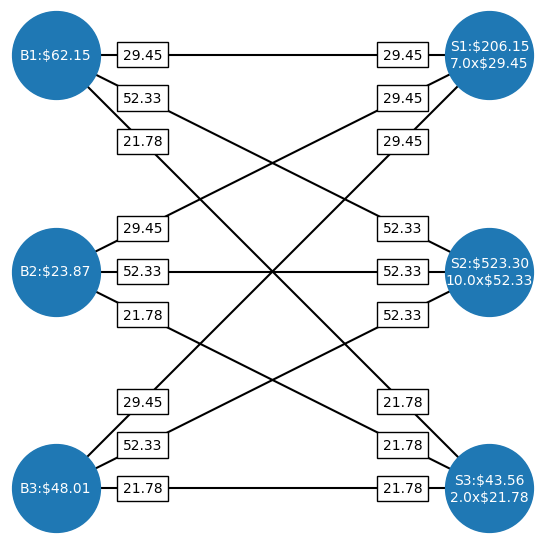

brokered
[[58.9  52.33 43.56]
 [ 0.    0.   21.78]
 [29.45  0.   43.56]]



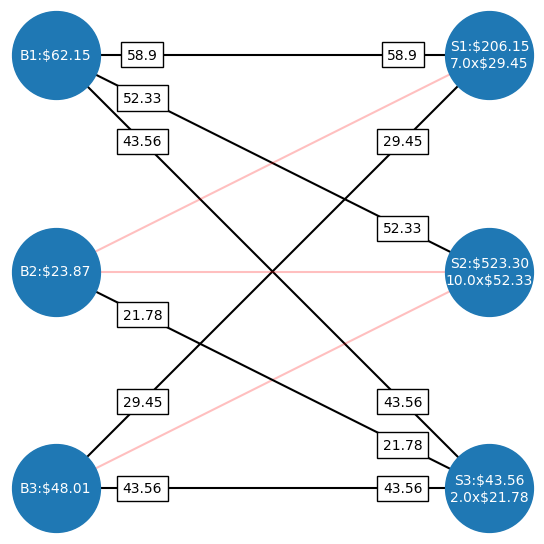

hung sol
[[ 0.   52.33  0.  ]
 [ 0.    0.   21.78]
 [29.45  0.    0.  ]]



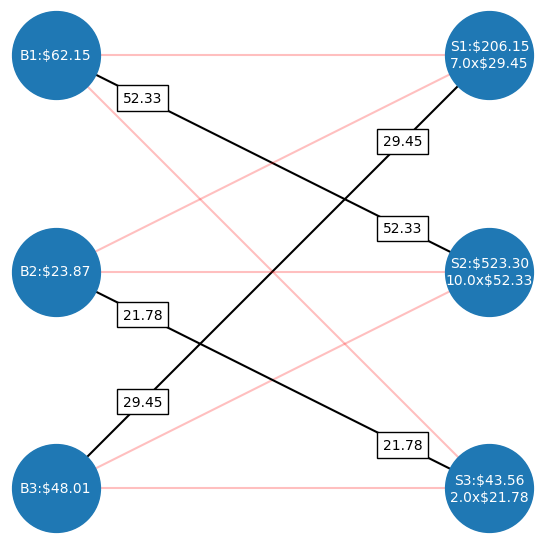

ilp
[[q_B1_S1 q_B1_S2 q_B1_S3]
 [q_B2_S1 q_B2_S2 q_B2_S3]
 [q_B3_S1 q_B3_S2 q_B3_S3]]



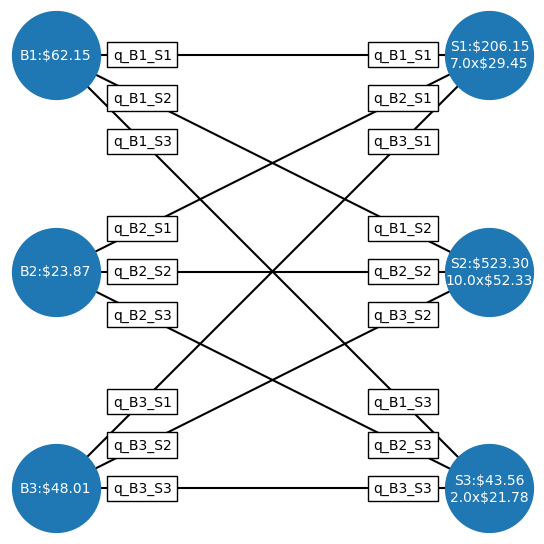

ilp sol
[[58.9   0.    0.  ]
 [ 0.    0.   21.78]
 [29.45  0.    0.  ]]



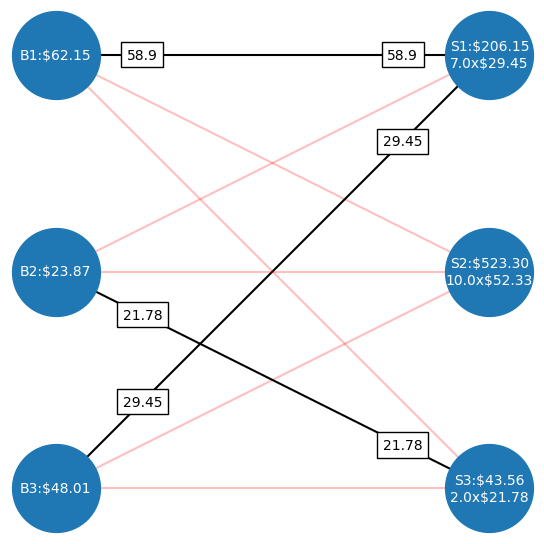

hilp sol
[[ 0.   52.33  0.  ]
 [ 0.    0.   21.78]
 [29.45  0.    0.  ]]



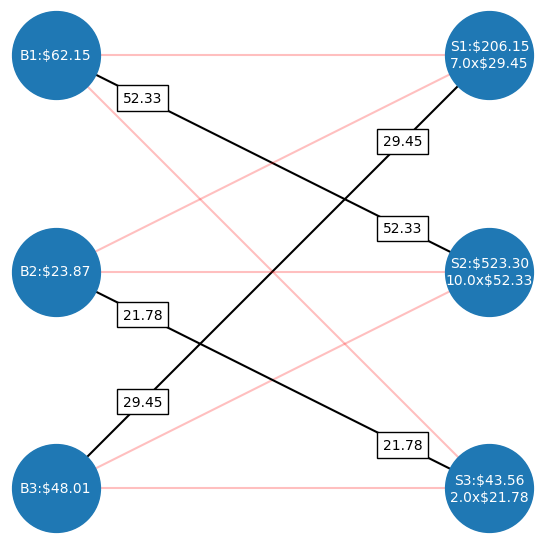

buyer total: 134.03
seller total: 773.01
theo solution: 134.03

hungarian solution: 103.56
ilp solution: 110.13
hilp solution: 103.56

theo waste: 638.98
hung waste: 669.45
ilp waste: 662.88
hilp waste: 669.45

End simulation 7



In [14]:
'''
* For each simulation display the:
- base Trading Matrix
-
'''

for simulation in simulations:
    print(simulation.title)

    for entity in simulation.entities.items():
        print(entity)

    print("")

    print("base")
    simulation.Display(simulation.base.matrix)

    print("brokered")
    simulation.Display(simulation.hung.matrix)
    print("hung sol")
    simulation.Display(simulation.hung.solution)

    print("ilp")
    simulation.Display(simulation.ilp.matrix)
    print("ilp sol")
    simulation.Display(simulation.ilp.solution)
    print("hilp sol")
    simulation.Display(simulation.hilp.solution)

    buyer_total = sum(buyer.total for buyer in simulation.buyers)
    seller_total = sum(seller.total for seller in simulation.sellers)
    max_lim = min(buyer_total, seller_total)

    print(f"buyer total: {buyer_total:.2f}")
    print(f"seller total: {seller_total:.2f}")
    print(f"theo solution: {max_lim:.2f}")

    print("")

    print(f"hungarian solution: {simulation.hung.total:.2f}")
    print(f"ilp solution: {simulation.ilp.total:.2f}")
    print(f"hilp solution: {simulation.hilp.total:.2f}")

    print("")

    min_waste = abs(buyer_total - seller_total)
    hung_waste = min_waste + (max_lim - simulation.hung.total)
    ilp_waste = min_waste + (max_lim - simulation.ilp.total)
    hilp_waste = min_waste + (max_lim - simulation.hilp.total)

    print(f"theo waste: {min_waste:.2f}")
    print(f"hung waste: {hung_waste:.2f}")
    print(f"ilp waste: {ilp_waste:.2f}")
    print(f"hilp waste: {hilp_waste:.2f}")

    print(f"\nEnd {simulation.title}\n")